# Processing

### Initialization

In [2]:
import numpy as np
sample = np.load('data\samplevideo.npy')
print(sample[0,:])

[ 134.  141.  128. ...,   81.   57.   74.]


In [3]:
def show_frame(frame):
    
    image = mp.imshow(frame.reshape((120,160)),cmap='Greys_r')

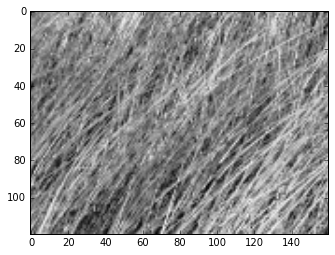

In [4]:
# Plot the first frame
import matplotlib.pyplot as mp
% matplotlib inline
show_frame(sample[0,:])

In [5]:
# Initialize the latent variable using PCA:
from sklearn.decomposition import PCA

N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample, 0)
sample_std = np.std(sample, 0)

sample = (sample - sample_mean)/sample_std # normalization
pca = PCA(n_components=Q) 
X = pca.fit_transform(sample) # performing PCA
print(X[0,:])

[ 23.73651164 -20.94734111  23.281226    22.6802055   -7.50919708
  34.30870091 -12.46201579   8.07417771 -12.95784813   9.80002935
  -6.88500422   0.63095893 -13.29798142  19.54781085  -4.42927045
   2.70507576  -5.53067023   4.97089492  -7.19820107  13.64289273]


## Kernels

<font color='red'>**Necessary kerns:**</font> 'lin','rbf','poly','ratquad','mlp','matern32'. Let's try to use GPy (Gaussian Process framework in python, from the Sheffield machine learning group). We'll get the following:

'lin' **class Linear**(input_dim, variances=None, ARD=False, active_dims=None, name='linear')

'rbf' **class RBF**(input_dim, variance=1.0, lengthscale=None, ARD=False, active_dims=None, name='rbf', useGPU=False, inv_l=False)

'poly' **class Poly**(input_dim, variance=1.0, scale=1.0, bias=1.0, order=3.0, active_dims=None, name='poly')

'ratquad' **class RatQuad**(input_dim, variance=1.0, lengthscale=None, power=2.0, ARD=False, active_dims=None, name='RatQuad')

'mlp' **class MLP**(input_dim, variance=1.0, weight_variance=1.0, bias_variance=1.0, ARD=False, active_dims=None, name='mlp')

'matern32' **class Matern32**(input_dim, variance=1.0, lengthscale=None, ARD=False, active_dims=None, name='Mat32')

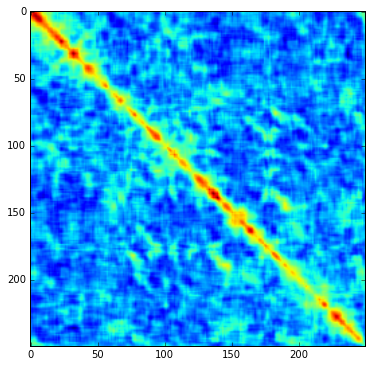

In [6]:
import GPy

fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Linear(Q).K(X,X))

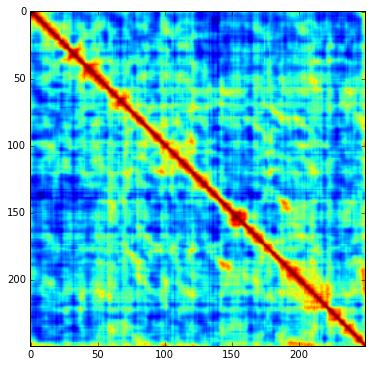

In [60]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.RBF(Q,1,100).K(X,X))

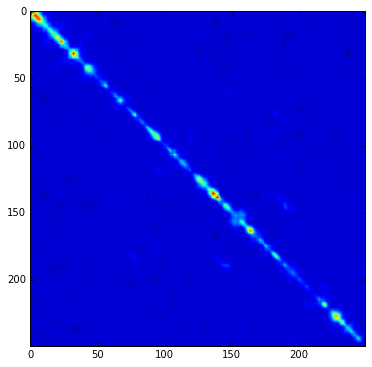

In [8]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Poly(Q,1,100).K(X,X))

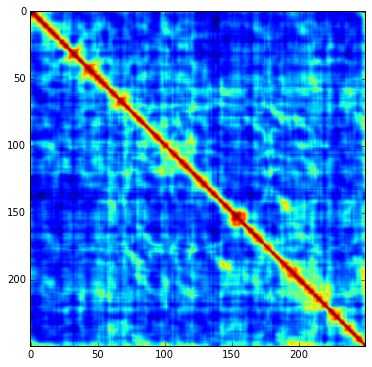

In [9]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.RatQuad(Q,1,100).K(X,X))

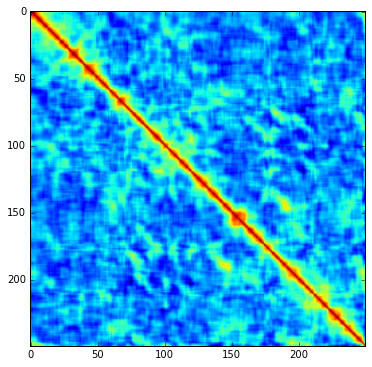

In [10]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.MLP(Q,1,100).K(X,X))

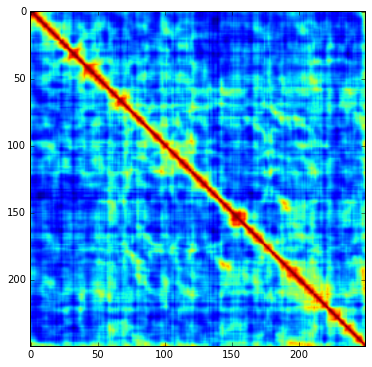

In [11]:
fig = mp.figure(figsize=(6,6)) # scale of the plot
mp.imshow(GPy.kern.Matern52(Q,1,100).K(X,X))

### Optimization

Kronecker Delta function:

In [84]:
def kd(x1,x2):
    
    if np.any(x1 == x2):
        return 1
    else:
        return 0

Kernel matrices:

In [13]:
def K_x(N,Q,w,x1,x2):
    
    k1 = GPy.kern.Linear(Q).K(x1[0:N-1,:],x2[0:N-1,:])
    k2 = GPy.kern.RBF(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k3 = GPy.kern.Poly(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k4 = GPy.kern.RatQuad(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k5 = GPy.kern.MLP(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    k6 = GPy.kern.Matern52(Q,1,100).K(x1[0:N-1,:],x2[0:N-1,:])
    
    return w[0]*k1 + w[1]*k2 + w[2]*k3 + w[3]*k4 + w[4]*k5 + w[5]*k6 + w[6]*kd(x1,x2)

In [14]:
def K_y(theta,x1,x2):
    
    return theta[0]*np.exp(-0.5*theta[1]*((x1 - x2)**2).sum(axis=-1)) + theta[2]*kd(x1,x2)

Functions to optimize:

In [15]:
def f1_likelihood(N,D,Q,Kx,Ky,X,Y,theta,lamb):
    
    C = 0
    Kx_inv = np.linalg.inv(Kx)
    Ky_inv = np.linalg.inv(Ky)
    part1 = 0.5*D*np.log(np.linalg.det(Ky))
    part2 = 0.5*np.matmul(np.transpose(Y),np.matmul(Ky_inv,Y))
    part3 = 0.5*Q*np.log(np.linalg.det(Kx_inv))
    part4 = 0.5*np.trace(Kx_inv*np.matmul(X[1:N],np.transpose(X)[1:N]))
    part5 = np.sum(theta)
    part6 = np.sum(lamb)
    
    return part1 + part2 + part3 + part4 + part5 + part6 + C

In [50]:
np.linalg.det(Ky)

-0.0

In [16]:
def f2_likelihood(N,Q,Kx,X,W):
    
    alpha = 1
    Kx_inv = np.linalg.inv(Kx)
    part1 = 0.5*Q*np.log(np.linalg.det(Kx_inv))
    part2 = 0.5*np.trace(Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N])))
    part3 = alpha*np.linalg.norm(W,2)

    return part1 + part2 + part3

Kx kernel matrix test:

[[ 4708.46577625  5301.51240898  5433.67350878 ...,  1264.3018179
   1722.7195948   1708.08131007]
 [ 5301.51240898  6422.41032769  6752.19375397 ...,  1365.89793108
   1877.76047981  1915.4848525 ]
 [ 5433.67350878  6752.19375397  7374.51659116 ...,  1472.90906741
   2007.54533349  2089.61590912]
 ..., 
 [ 1264.3018179   1365.89793108  1472.90906741 ...,  4020.46086512
   2855.78261545  1326.66019282]
 [ 1722.7195948   1877.76047981  2007.54533349 ...,  2855.78261545
   2753.86384763  1804.35767487]
 [ 1708.08131007  1915.4848525   2089.61590912 ...,  1326.66019282
   1804.35767487  1936.77273337]]


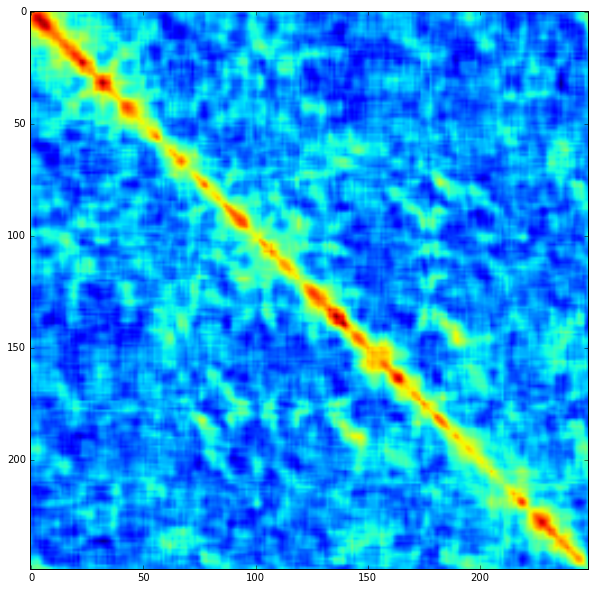

In [17]:
weights = [1, 1, 0, 1, 1, 1, 1]
Kx = K_x(N,Q,weights,X,X)

print(Kx)

fig = mp.figure(figsize=(10,10)) # scale of the plot
image = mp.imshow(Kx)

Ky kernel matrix test:

[[ 10001.          10000.99997364  10000.99993927 ...,  10000.99979932
   10000.99983868  10000.99980827]
 [ 10000.99997364  10001.          10000.99998539 ...,  10000.99972916
   10000.99977376  10000.9997363 ]
 [ 10000.99993927  10000.99998539  10001.         ...,  10000.99969455
   10000.99974358  10000.99969495]
 ..., 
 [ 10000.99979932  10000.99972916  10000.99969455 ...,  10001.
   10000.99994597  10000.99987842]
 [ 10000.99983868  10000.99977376  10000.99974358 ...,  10000.99994597
   10001.          10000.99997175]
 [ 10000.99980827  10000.9997363   10000.99969495 ...,  10000.99987842
   10000.99997175  10001.        ]]


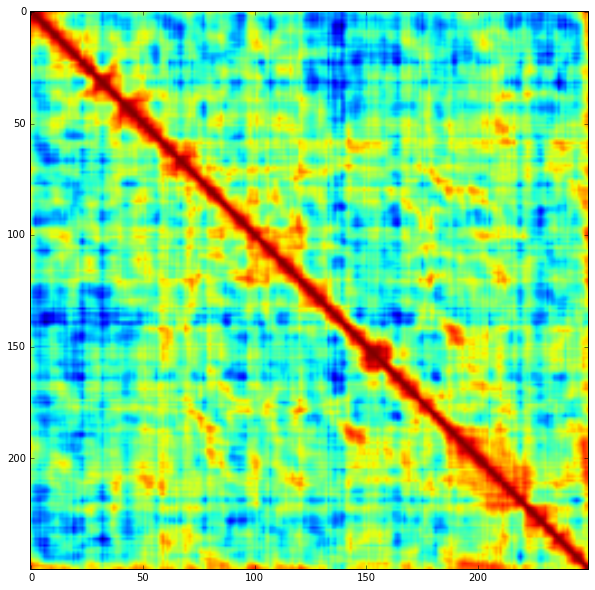

In [85]:
theta = [1, 0.0000001, 10000]
Ky = K_y(theta,X.reshape(1,-1,Q),X.reshape(-1,1,Q))

print(Ky)

fig = mp.figure(figsize=(10,10)) # scale of the plot
image = mp.imshow(Ky)

f1_likelihood test:

In [227]:
a = [[1,0,0],[0,1,0],[0,0,1]]
x = [9,8,7,6]
c = [1,2,3,4,5,6]
#print(f2_likelihood(20,4,a,x,c))

lamb = [1, 1, 1, 1, 1, 1]

# f1_likelihood(N,D,Q,Kx,Ky,X,Y,theta,lamb)
print(f1_likelihood(N,D,Q,Kx,Ky,X,sample,theta,lamb))

233.039392014
2747089.24846


f2_likelihood test:

In [227]:
a = [[1,0,0],[0,1,0],[0,0,1]]
x = [9,8,7,6]
c = [1,2,3,4,5,6]
print(f2_likelihood(20,4,a,x,c))

print(f2_likelihood(N,Q,Kx,X,weights))

233.039392014
2747089.24846


Gradients of functions f1 and f2:

In [171]:
def f1_gradient(Q,N,D,Kx,Ky,X,Y,theta,lamb):
    
    Kx_inv = np.linalg.inv(Kx)    
    Ky_inv = np.linalg.inv(Ky)
    
    dL_dX = dL_dKy * dKy_dX + dL_dKx * dKx_dX + dL_dx2 * dx2_dX
    
    dL_dKy = 0.5*D*np.transpose(Ky_inv)-0.5*np.transpose(np.matmul((Ky_inv*np.matmul(Y,np.transpose(Y))),Ky_inv))
    dL_dKx = 0.5*Q*np.transpose(Kx_inv)-0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))
    dL_dx2 = 0.5*(np.matmul(Kx_inv,X[1:N])+np.matmul(np.transpose(Kx_inv),X[1:N]))
    
    #dKy_dX = ?
    #dKx_dX = ?
    #dx2_dX = ?
    
    dL_dTht1 = 0.5*D*np.trace(Ky_inv*dKy_dTht)
    dL_dTht2 = 0.5*np.transpose(np.matmul((Ky_inv*np.matmul(Y,np.transpose(Y))),Ky_inv))*dKy_dTht
    dL_dTht3 = 1/theta
    #dKy_dTht = ?
    
    dL_dLam1 = 0.5*Q*np.trace(Kx_inv*dKx_dLam)
    dL_dLam2 = 0.5*np.transpose(np.matmul((Kx_inv*np.matmul(X[1:N],np.transpose(X[1:N]))),Kx_inv))*dKx_dTLam
    dL_dLam3 = 1/lamb
    #dKx_dLam = ?
    
    dL_dTht = dL_dTht1 - dL_dTht2 + dL_dTht3
    
    dL_dLam = dL_dLam1 - dL_dLam2 + dL_dLam3
    
    return [dL_dX, dL_dTheta, dL_dLam]

In [170]:
def f2_gradient(Q,N,Kx,X,W):
    
    #params = mk_weightsConstrain(params)
    
    #[Xin, Xout] = mk_priorIO(X, segments)
    
    Kx_inv = np.linalg.inv(Kx)
    #dL_dKx = -Q/2*invKx + 0.5*invKx*(Xout*Xout')*invKx
    
    #g = zeros(length(kern.comp),1)
    
    #for i = 1:length(kern.comp)
    #    g(i) = sum(sum(dL_dKx .* Kx{i}))
    
    norm2 = 1/np.linalg.norm(W,2)
    
    #for i = 1:length(kern.comp)
    #    g(i) = g(i) + norm2 * params(i)
    
    g = g/np.linalg.norm(g2)
    
    return -np.transpose(g)

In [20]:
# [params, options, flog] = scg('mk_likelihood', params, options, 'mk_gradient', Y, segments, kern)

# check weight_likelihood and mk_likelihood with Kx and Ky and rewrite if necessary

#write mk_weightsConstrain function
#write mk_priorIO function
#finish function weight_gradient

# search for kern gradients

# find scg function for Python